In [43]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from pca import pca
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import  matplotlib.pyplot as plt
import pickle
import joblib

In [17]:
accept_rate = pd.read_csv("datasets/Admission and Test Scores/ADM_2015-2021_data.csv")
accept_rate = accept_rate.groupby('unitid').mean().reset_index()
public_pnp_finances = pd.read_csv("datasets/Institutional Finances/F_F2_1415-1920_data.csv", low_memory=False)
public_pnp_finances = public_pnp_finances.groupby('unitid').mean().reset_index()
enrollment = pd.read_csv("datasets/Fall Enrollment/EFD_2015-2020_data.csv")
enrollment = enrollment.groupby('unitid').mean().reset_index()
yield_df = pd.merge(accept_rate, enrollment, on='unitid', how='inner')
yield_df = pd.merge(yield_df, public_pnp_finances, on='unitid', how='inner')
yield_df = yield_df.drop(['year_x', 'year_y', 'year'], axis=1)
yield_df['yield'] = yield_df['grcohrt']/yield_df['admssn']
yield_df['log_yield_per_dollar'] = np.log(1000000000*yield_df['yield']/yield_df['f2a02'])
yield_df.replace([np.inf, -np.inf], np.nan, inplace=True)
yield_df = yield_df.fillna(yield_df.median())
X = yield_df[list(public_pnp_finances)[1:-1]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
model = pca()
X_pca_array = model.fit_transform(X_scaled)
best_feats = list(set(X_pca_array['topfeat'][X_pca_array['topfeat']['type'] == 'best']['feature']))
print(best_feats)
all_cols = ['unitid', 'log_yield_per_dollar'] + best_feats + ['f2b02']
yield_efficiency = yield_df[all_cols]
yield_efficiency = yield_efficiency.rename(columns=
                                {'f2b02':'Total expenses',
                                 'f2e094':'Hospital services-Operation and maintenance of plant',
                                 'f2d084b':'Private grants, and contracts - Permanently restricted',
                                 'f2d143':'Independent operations revenue - Temporarily restricted',
                                 'f2d042':'Local appropriations - Unrestricted',
                                 'f2a19':'Property, Plant, and Equipment, net of accumulated depreciation',
                                 'f2e101':'Independent operations-Total Amount',
                                 'f2d144':'Independent operations revenue - Permanently restricted',
                                 'f2h03d':'Other changes in value of endowment net assets',
                                 'f2e126':'Other expenses-Interest',
                                 'f2c152':'Discounts and allowances from local government grants applied to auxiliary enterprises',
                                 'f2e105':'Independent operations-Depreciation',
                                 'f2d054':'Federal grants and contracts - Pemanently restricted',
                                 'f2d174':'Net assets released from restriction - Permanently restricted',
                                 'f2d074':'Local grants and contracts - Permanently restricted',
                                 'f2c141':'Discounts and allowances from state government grants applied to tuition and fees',
                                 'f2d04':'Local appropriations - Total',
                                 'f2d023':'Federal appropriations - Temporarily restricted',
                                 'f2h03a':'New gifts and additions',
                                 'f2e091':'Hospital services-Total amount',
                                 'f2d153':'Other revenue - Temporarily restricted',
                                 'f2a20':'Intangible Assets, net of accumulated amortization',
                                 'f2e107':'Independent operations-All other',
                                 'f2c142':'Discounts and allowances from state government grants applied to auxiliary enterprises',
                                 'f2d033':'State appropriations - Temporarily restricted',
                                 'f2a05b':'Temporarily restricted net assets',
                                 'f2c162':'Discounts and allowances from endowments and gifts applied to auxiliary enterprises',
                                 'f2b06':'Adjustments to beginning of year net assets',
                                 'f2d053':'Federal grants and contracts - Temporarily restricted',
                                 'f2d154':'Other revenue - Permanently restricted',
                                 'f2c09':'Allowances applied to auxiliary enterprise revenues',
                                 'f2c132':'Discounts and allowances from other federal grants applied to auxiliary enterprises',
                                 'f2e042':'Academic support-Salaries and wages',
                                 'f2c151':'Discounts and allowances from local government grants applied to tuition and fees',
                                 'f2d07':'Local grants and contracts - Total',
                                 'f2d014':'Tuition and fees - Permanently restricted'})
negs = []
for col in yield_efficiency:
    if col not in {'unitid','log_yield_per_dollar', 'Total expenses'}:
        if yield_efficiency[col].min() < 0:
            print(col)
            negs.append(col)
        else:
            yield_efficiency[col + '_per_dollar'] = yield_efficiency[col]/yield_efficiency['Total expenses']
yield_efficiency = yield_efficiency.drop(negs, axis=1)
cols = list(yield_efficiency)[:2] + list(yield_efficiency)[31:]
autofeature_per_dollar_expense = yield_efficiency[cols]
autofeature_per_dollar_expense

/var/folders/9w/fw9jqmmd0_1746t9vj_vtsv40000gn/T/ipykernel_91021/1859983938.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  accept_rate = accept_rate.groupby('unitid').mean().reset_index()
/var/folders/9w/fw9jqmmd0_1746t9vj_vtsv40000gn/T/ipykernel_91021/1859983938.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  public_pnp_finances = public_pnp_finances.groupby('unitid').mean().reset_index()


[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [226] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [43] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [226] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[43]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
['f2c152', 'f2d174', 'f2h03d', 'f2c151', 'f2d143', 'f2c162', 'f2d023', 'f2d054', 'f2d04', 'f2d042', 'f2d084b', 'f2c142', 'f2e042', 'f2e094', 'f2d074', 'f2d144', 'f2e126', 'f2d07', 'f2e101', 'f2d154', 'f2b06', 'f2a20', 'f2c132', 'f2a05b', 'f2a19', 'f2d033', 'f2d053', 'f2e105', 'f2h03a', 'f2c09', 'f2e107', 'f2e091', 'f2d014', 'f2d153', 'f2c141']
Net assets released from restriction - Permanently 

,unitid,log_yield_per_dollar,Total expenses,Discounts and allowances from local government grants applied to auxiliary enterprises_per_dollar,Discounts and allowances from local government grants applied to tuition and fees_per_dollar,Independent operations revenue - Temporarily restricted_per_dollar,Discounts and allowances from endowments and gifts applied to auxiliary enterprises_per_dollar,Federal appropriations - Temporarily restricted_per_dollar,Federal grants and contracts - Pemanently restricted_per_dollar,Local appropriations - Total_per_dollar,...,"Property, Plant, and Equipment, net of accumulated depreciation_per_dollar",State appropriations - Temporarily restricted_per_dollar,Federal grants and contracts - Temporarily restricted_per_dollar,Independent operations-Depreciation_per_dollar,New gifts and additions_per_dollar,Allowances applied to auxiliary enterprise revenues_per_dollar,Independent operations-All other_per_dollar,Hospital services-Total amount_per_dollar,Tuition and fees - Permanently restricted_per_dollar,Discounts and allowances from state government grants applied to tuition and fees_per_dollar
0,100937,0.111066,4.639203e+07,0.0,0.093061,0.0,0.000000,0.0,0.0,0.0,...,2.083279,0.0,0.000000,0.0,0.015603,0.000000,0.0,0.000000,0.0,0.000000
1,101073,2.544717,1.092255e+07,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.941256,0.0,0.093218,0.0,0.085327,0.000000,0.0,0.000000,0.0,0.000000
2,101189,1.001058,4.390331e+07,0.0,0.000000,0.0,0.000597,0.0,0.0,0.0,...,1.190197,0.0,0.031491,0.0,0.003167,0.023166,0.0,0.000000,0.0,0.002328
3,101365,2.801799,5.469524e+06,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.603472,0.0,0.000000,0.0,0.170397,0.000000,0.0,0.000000,0.0,0.000000
4,101435,0.887857,2.221401e+07,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,1.320212,0.0,0.000000,0.0,0.018551,0.000000,0.0,0.000000,0.0,0.018826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,494463,0.661397,3.784147e+07,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,1.366632,0.0,0.000000,0.0,0.024629,0.000000,0.0,0.000000,0.0,0.000000
1334,494685,6.594540,2.480739e+06,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.165267,0.0,0.000000,0.0,0.375692,0.000000,0.0,0.000000,0.0,0.000000
1335,495031,5.185335,1.668280e+06,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,1.741043,0.0,0.000000,0.0,0.558655,0.000000,0.0,0.000000,0.0,0.000000
1336,495767,-4.521554,7.653947e+09,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.758724,0.0,0.000000,0.0,0.011193,0.000000,0.0,0.340573,0.0,0.000000


(array([1.262e+03, 3.500e+01, 1.200e+01, 9.000e+00, 7.000e+00, 2.000e+00,
        4.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.08721108e-11, 2.76101383e-07, 5.52191894e-07, 8.28282404e-07,
        1.10437291e-06, 1.38046343e-06, 1.65655394e-06, 1.93264445e-06,
        2.20873496e-06, 2.48482547e-06, 2.76091598e-06, 3.03700649e-06,
        3.31309700e-06, 3.58918751e-06, 3.86527802e-06, 4.14136853e-06,
        4.41745904e-06, 4.69354955e-06, 4.96964007e-06, 5.24573058e-06,
        5.52182109e-06, 5.79791160e-06, 6.07400211e-06, 6.35009262e-06,
        6.62618313e-06, 6.90227364e-06, 7.17836415e-06, 7.45445466e-06,
        7.73054517e-06, 8.00663568e-06, 8.28272619e-06]),
 <BarContainer object of 30 artists>)

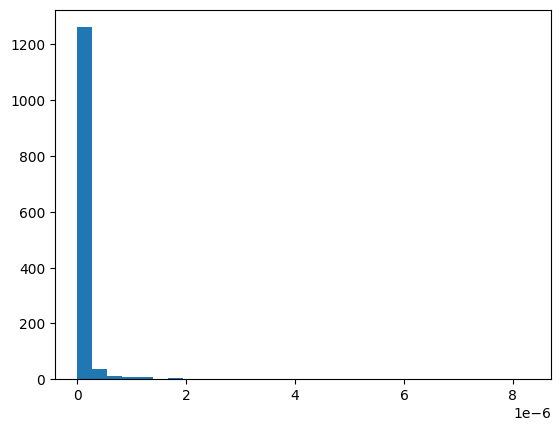

In [25]:
plt.hist(yield_df['yield']/yield_df['f2a02'], bins=30)

In [21]:
x = autofeature_per_dollar_expense.iloc[:, 3:]
y = autofeature_per_dollar_expense['log_yield_per_dollar']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=5)
grid = {
    'n_estimators': [7, 8, 9, 10, 11, 12],
    'max_depth' : [4, 5, 6, 7],
    'eta' : [0.01, 0.05, 0.1, 0.15],
    'grow_policy' : ['depthwise', 'lossguide']
}

model_a = XGBRegressor()
xgbr_cv_a = RandomizedSearchCV(estimator=model_a, param_distributions=grid, cv=10, n_jobs=-1)
xgbr_cv_a.fit(x_train, y_train)
res_a = xgbr_cv_a.best_params_
print(res_a)
xgbr_a = XGBRegressor(n_estimators=res_a["n_estimators"], max_depth=res_a["max_depth"], eta=res_a["eta"], grow_policy=res_a["grow_policy"], eval_metric='rmse').fit(x_train, y_train)
score = xgbr_a.score(x_test, y_test)
preds = xgbr_a.predict(x_test)
mse = mean_squared_error(y_test, preds)
print("R^2 Score: ", score)
print("MSE: ", mse)
print("RMSE: ", mse**(0.5))

/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost

{'n_estimators': 9, 'max_depth': 5, 'grow_policy': 'depthwise', 'eta': 0.15}
R^2 Score:  0.5312673490473478
MSE:  2.844349865833351
RMSE:  1.6865200460810867


In [4]:
xgbr_a.get_booster().get_score(importance_type='weight')

{'Total expenses': 378.0,
 'Discounts and allowances from local government grants applied to auxiliary enterprises_per_dollar': 5.0,
 'Discounts and allowances from local government grants applied to tuition and fees_per_dollar': 7.0,
 'Independent operations revenue - Temporarily restricted_per_dollar': 19.0,
 'Discounts and allowances from endowments and gifts applied to auxiliary enterprises_per_dollar': 12.0,
 'Federal grants and contracts - Pemanently restricted_per_dollar': 2.0,
 'Local appropriations - Unrestricted_per_dollar': 1.0,
 'Discounts and allowances from state government grants applied to auxiliary enterprises_per_dollar': 3.0,
 'Academic support-Salaries and wages_per_dollar': 151.0,
 'Local grants and contracts - Permanently restricted_per_dollar': 3.0,
 'Independent operations revenue - Permanently restricted_per_dollar': 2.0,
 'Other expenses-Interest_per_dollar': 15.0,
 'Local grants and contracts - Total_per_dollar': 24.0,
 'Independent operations-Total Amount_pe

In [5]:
filename = 'autoselected_features_yield_per_dollar.sav'
pickle.dump(xgbr_a, open(filename, 'wb'))

In [6]:
manual_per_dollar_expense = yield_df[['unitid', 'log_yield_per_dollar', 'f2b02', 'f2c05', 'f2c06', 'f2d11', 'f2d12', 'f2e011', 'f2e021', 'f2e031', 'f2e041', 'f2e051', 'f2e061', 'f2e071', 'f2e081']]
manual_per_dollar_expense

,unitid,log_yield_per_dollar,f2b02,f2c05,f2c06,f2d11,f2d12,f2e011,f2e021,f2e031,f2e041,f2e051,f2e061,f2e071,f2e081
0,100937,0.111066,4.639203e+07,5.578125e+06,1.619607e+07,0.0,1.520883e+07,1.432264e+07,0.0,0.0,3.283277e+06,9.475854e+06,9.170287e+06,9.820546e+06,319422.333333
1,101073,2.544717,1.092255e+07,0.000000e+00,7.310033e+05,0.0,1.950601e+06,3.382461e+06,0.0,0.0,4.764743e+05,9.262417e+05,3.278771e+06,2.858568e+06,0.000000
2,101189,1.001058,4.390331e+07,5.326997e+05,1.192251e+07,0.0,3.216318e+06,1.745256e+07,0.0,0.0,3.079230e+06,9.203930e+06,8.663598e+06,4.439644e+06,0.000000
3,101365,2.801799,5.469524e+06,0.000000e+00,1.017367e+06,0.0,0.000000e+00,2.209669e+06,0.0,0.0,3.064165e+05,1.634070e+06,9.270015e+05,0.000000e+00,0.000000
4,101435,0.887857,2.221401e+07,3.990944e+06,6.483747e+06,0.0,4.608309e+06,6.681050e+06,0.0,0.0,1.637742e+06,6.598691e+06,3.879128e+06,3.417398e+06,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,494463,0.661397,3.784147e+07,0.000000e+00,5.695100e+05,0.0,5.448486e+06,6.537635e+05,0.0,0.0,2.461665e+05,1.727585e+05,2.818965e+05,4.616294e+06,0.000000
1334,494685,6.594540,2.480739e+06,2.489000e+04,1.626265e+05,0.0,0.000000e+00,7.116285e+05,0.0,0.0,2.914880e+05,7.338835e+05,6.517215e+05,0.000000e+00,0.000000
1335,495031,5.185335,1.668280e+06,0.000000e+00,1.061202e+06,0.0,0.000000e+00,5.237670e+05,0.0,42663.0,0.000000e+00,1.466910e+05,1.580580e+05,0.000000e+00,797101.000000
1336,495767,-4.521554,7.653947e+09,8.661300e+07,1.397470e+08,111328000.0,3.971200e+08,1.370535e+09,944235000.0,111261000.0,3.827030e+08,1.995680e+08,3.921340e+08,4.160090e+08,0.000000


In [7]:
manual_per_dollar_expense = manual_per_dollar_expense.rename(columns=
                                                            {
                                                                'f2b02':'Total expenses',
                                                                'f2c05':'Institutional grants (funded)',
                                                                'f2c06':'Institutional grants (unfunded)',
                                                                'f2d11':'Sales and services of educational activities - Total',
                                                                'f2d12':'Sales and services of auxiliary enterprises - Total',
                                                                'f2e011':'Instruction-Total amount',
                                                                'f2e021':'Research-Total amount',
                                                                'f2e031':'Public service-Total amount',
                                                                'f2e041':'Academic support-Total amount',
                                                                'f2e051':'Student service-Total amount',
                                                                'f2e061':'Institutional support-Total amount',
                                                                'f2e071':'Auxiliary enterprises-Total amount',
                                                                'f2e081':'Net grant aid to students-Total amount'
                                                            })
m_negs = []
for i in manual_per_dollar_expense:
    if i not in {'unitid', 'log_yield_per_dollar', 'Total expenses'}:
        if manual_per_dollar_expense[i].min() < 0:
            print(i)
            m_negs.append(i)
        else:
            manual_per_dollar_expense[i + "_per_dollar"] = manual_per_dollar_expense[i]/manual_per_dollar_expense['Total expenses']
            m_negs.append(i)
manual_per_dollar_expense = manual_per_dollar_expense.drop(m_negs, axis=1)
manual_per_dollar_expense

,unitid,log_yield_per_dollar,Total expenses,Institutional grants (funded)_per_dollar,Institutional grants (unfunded)_per_dollar,Sales and services of educational activities - Total_per_dollar,Sales and services of auxiliary enterprises - Total_per_dollar,Instruction-Total amount_per_dollar,Research-Total amount_per_dollar,Public service-Total amount_per_dollar,Academic support-Total amount_per_dollar,Student service-Total amount_per_dollar,Institutional support-Total amount_per_dollar,Auxiliary enterprises-Total amount_per_dollar,Net grant aid to students-Total amount_per_dollar
0,100937,0.111066,4.639203e+07,0.120239,0.349113,0.000000,0.327833,0.308731,0.000000,0.000000,0.070772,0.204256,0.197669,0.211686,0.006885
1,101073,2.544717,1.092255e+07,0.000000,0.066926,0.000000,0.178585,0.309677,0.000000,0.000000,0.043623,0.084801,0.300184,0.261713,0.000000
2,101189,1.001058,4.390331e+07,0.012133,0.271563,0.000000,0.073259,0.397523,0.000000,0.000000,0.070137,0.209641,0.197334,0.101123,0.000000
3,101365,2.801799,5.469524e+06,0.000000,0.186007,0.000000,0.000000,0.403997,0.000000,0.000000,0.056023,0.298759,0.169485,0.000000,0.000000
4,101435,0.887857,2.221401e+07,0.179659,0.291876,0.000000,0.207451,0.300758,0.000000,0.000000,0.073726,0.297051,0.174625,0.153840,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,494463,0.661397,3.784147e+07,0.000000,0.015050,0.000000,0.143982,0.017276,0.000000,0.000000,0.006505,0.004565,0.007449,0.121990,0.000000
1334,494685,6.594540,2.480739e+06,0.010033,0.065556,0.000000,0.000000,0.286861,0.000000,0.000000,0.117500,0.295833,0.262713,0.000000,0.000000
1335,495031,5.185335,1.668280e+06,0.000000,0.636105,0.000000,0.000000,0.313956,0.000000,0.025573,0.000000,0.087929,0.094743,0.000000,0.477798
1336,495767,-4.521554,7.653947e+09,0.011316,0.018258,0.014545,0.051884,0.179063,0.123366,0.014536,0.050001,0.026074,0.051233,0.054352,0.000000


In [8]:
x = manual_per_dollar_expense.iloc[:, 2:]
y = manual_per_dollar_expense['log_yield_per_dollar']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=7)
grid = {
    'n_estimators': [5, 7, 10, 12, 15],
    'max_depth' : [3, 4, 5, 6, 7, 8],
    'eta' : [0.01, 0.05, 0.1, 0.15],
    'grow_policy' : ['depthwise', 'lossguide']
}

model_m = XGBRegressor()
xgbr_cv_m = RandomizedSearchCV(estimator=model_m, param_distributions=grid, cv=5, n_jobs=-1)
xgbr_cv_m.fit(x_train, y_train)
res_m = xgbr_cv_m.best_params_
print(res_m)
xgbr_m = XGBRegressor(n_estimators=res_m["n_estimators"], max_depth=res_m["max_depth"], eta=res_m["eta"], grow_policy=res_m["grow_policy"], eval_metric='rmse').fit(x_train, y_train)
score = xgbr_m.score(x_test, y_test)
preds = xgbr_m.predict(x_test)
mse = mean_squared_error(y_test, preds)
print("Test set R^2 Score: ", score)
print("MSE: ", mse)
print("RMSE: ", mse**(0.5))

/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost

{'n_estimators': 15, 'max_depth': 3, 'grow_policy': 'lossguide', 'eta': 0.15}
Test set R^2 Score:  0.8137928278244232
MSE:  0.8136999167371837
RMSE:  0.9020531673561064


/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [9]:
xgbr_m.get_booster().get_score(importance_type='weight')

{'Total expenses': 68.0,
 'Institutional grants (funded)_per_dollar': 7.0,
 'Institutional grants (unfunded)_per_dollar': 4.0,
 'Sales and services of educational activities - Total_per_dollar': 9.0,
 'Instruction-Total amount_per_dollar': 1.0,
 'Research-Total amount_per_dollar': 4.0,
 'Public service-Total amount_per_dollar': 1.0,
 'Academic support-Total amount_per_dollar': 1.0,
 'Student service-Total amount_per_dollar': 1.0,
 'Institutional support-Total amount_per_dollar': 3.0,
 'Auxiliary enterprises-Total amount_per_dollar': 5.0,
 'Net grant aid to students-Total amount_per_dollar': 1.0}

In [10]:
filename = 'manual_features_yield_per_dollar.sav'
pickle.dump(xgbr_m, open(filename, 'wb'))

In [14]:
autofeature_per_dollar_expense.to_csv('autofeature_per_dollar_expense.csv')
manual_per_dollar_expense.to_csv('manual_per_dollar_expense.csv')

In [15]:
xgbr_m.save_model('manual_features_yield_per_dollar.json')
xgbr_a.save_model('autoselected_features_yield_per_dollar.json')

In [40]:
x = manual_per_dollar_expense.iloc[:, 2:]
y = manual_per_dollar_expense['log_yield_per_dollar']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=23)
grid = { 
    'n_estimators': [10, 11, 12, 13, 14, 15],
    'max_features': ['auto','sqrt','log2'],
    'max_depth' : [6, 7, 8, 9]
}

model_rfr_m = RandomForestRegressor()
rfr_cv_m = RandomizedSearchCV(estimator=model_rfr_m, param_distributions=grid, cv=15, n_jobs=-1)
rfr_cv_m.fit(x_train, y_train)
res_rfr_m = rfr_cv_m.best_params_
print(res_rfr_m)
rfr_m = RandomForestRegressor(bootstrap='True', criterion='squared_error', oob_score='True', n_estimators=res_rfr_m["n_estimators"], max_features=res_rfr_m['max_features'], max_depth=res_rfr_m["max_depth"]).fit(x_train, y_train)
score = rfr_m.score(x_test, y_test)
preds = rfr_m.predict(x_test)
mse = mean_squared_error(y_test, preds)
print("Test set R^2 Score: ", score)
print("MSE: ", mse)
print("RMSE: ", mse**(0.5))

/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1

{'n_estimators': 12, 'max_features': 'auto', 'max_depth': 6}
Test set R^2 Score:  0.849353011689917
MSE:  0.5981511238692004
RMSE:  0.7734023040237211


/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [44]:
joblib.dump(rfr_m, "manual_yield_rfr.joblib")

['manual_yield_rfr.joblib']